In [1]:
import numpy as np
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [2]:
Dataset = pd.read_csv('Dataset.csv')


In [3]:
Dataset['Date'] = pd.to_datetime(Dataset.Date, format="%d-%m-%Y")


In [4]:
Data_Bar = Dataset[['Date', 'Bar Amount']]
Data_Bar = Data_Bar.set_index('Date')
Data_Bar.head()


,Bar Amount
Date,
2013-09-01,7760
2013-09-02,25239
2013-09-03,4127
2013-09-04,2273
2013-09-05,12505


In [5]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [6]:
split_date_r = '01-Jan-2019'
Data_Bar_Train = Data_Bar.loc[Data_Bar.index <= split_date_r].copy()
Data_Bar_Test = Data_Bar.loc[Data_Bar.index > split_date_r].copy()


In [7]:
X_Train_B, Y_Train_B = create_features(
    Data_Bar_Train, label='Bar Amount')
X_Test_B, Y_Test_B = create_features(Data_Bar_Test, label='Bar Amount')


<ipython-input-5-7d898388bd09>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [8]:
XGB_B = xgb.XGBRegressor(n_estimators=1000)
XGB_B.fit(X_Train_B, Y_Train_B,
        eval_set=[(X_Train_B, Y_Train_B), (X_Test_B, Y_Test_B)],
        early_stopping_rounds=50,
        verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

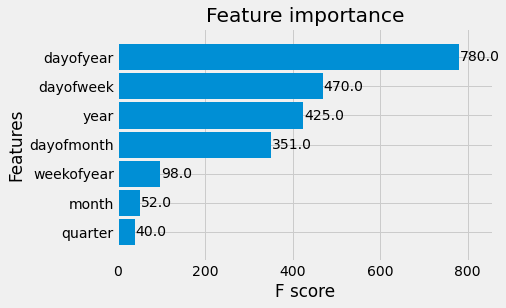

In [9]:
plot_importance(XGB_B, height=0.9)


In [10]:
Data_Bar_Test['Bar Amount Prediction'] = XGB_B.predict(X_Test_B)
Data_Bar_all = pd.concat([Data_Bar_Test, Data_Bar_Train], sort=False)


<AxesSubplot:xlabel='Date'>

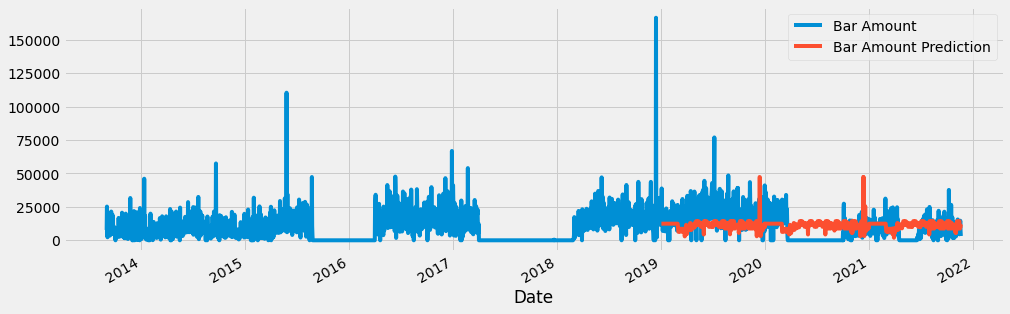

In [11]:
Data_Bar_all[['Bar Amount', 'Bar Amount Prediction']].plot(
    figsize=(15, 5))


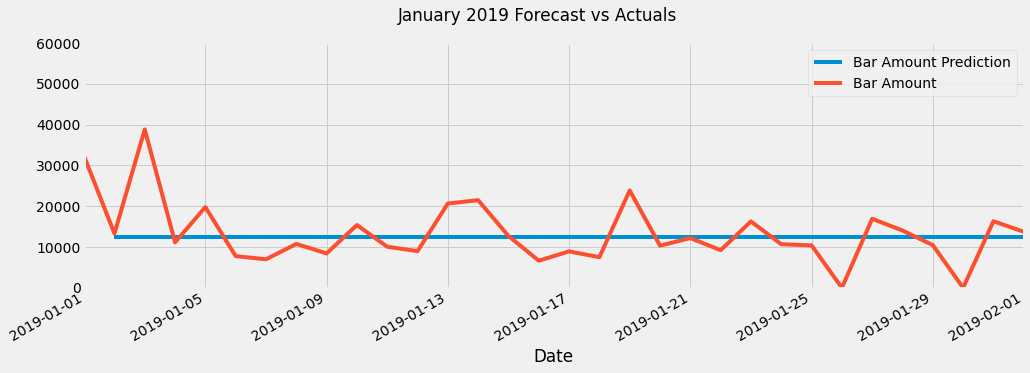

In [12]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
Data_Bar_all[['Bar Amount Prediction', 'Bar Amount']].plot(ax=ax,
                                                style=['-', '-'])
ax.set_xbound(lower='01-01-2019', upper='02-01-2019')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2019 Forecast vs Actuals')


In [13]:
mean_squared_error(y_true=Data_Bar_Test['Bar Amount'],
                   y_pred=Data_Bar_Test['Bar Amount Prediction'])


122849065.47115543

In [14]:
mean_absolute_error(y_true=Data_Bar_Test['Bar Amount'],
                    y_pred=Data_Bar_Test['Bar Amount Prediction'])


9123.116815608677

In [15]:
Data_Bar_Test['error'] = Data_Bar_Test['Bar Amount'] - \
    Data_Bar_Test['Bar Amount Prediction']
Data_Bar_Test['abs_error'] = Data_Bar_Test['error'].apply(np.abs)
error_by_day = Data_Bar_Test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['Bar Amount', 'Bar Amount Prediction', 'error', 'abs_error']]


In [16]:
error_by_day.sort_values('error', ascending=True).head(10)


Bar Amount  Bar Amount Prediction         error  \
year month dayofmonth                                                    
2020 12    13               11839           47133.097656 -35294.097656   
           11               15884           47383.671875 -31499.671875   
2019 12    13               17699           47383.671875 -29684.671875   
           14               20398           47133.097656 -26735.097656   
2020 12    12                8035           30240.105469 -22205.105469   
           18                4535           25545.156250 -21010.156250   
2021 6     12                   0           14330.003906 -14330.003906   
2020 8     1                    0           14330.003906 -14330.003906   
           2                    0           14330.003906 -14330.003906   
           8                    0           14330.003906 -14330.003906   

                          abs_error  
year month dayofmonth                
2020 12    13          35294.097656  
           11          31499.671875  
2019 12    13          29684.671875  
           14          26735.097656  
2020 12    12          22205.105469  
           18          21010.156250  
2021 6     12          14330.003906  
2020 8     1           14330.003906  
           2           14330.003906  
           8           14330.003906

In [17]:
error_by_day.sort_values('abs_error', ascending=False).head(10)


Bar Amount  Bar Amount Prediction         error  \
year month dayofmonth                                                    
2019 7     7                76993           14330.003906  62662.996094   
     8     25               48541           10449.300781  38091.699219   
     7     6                51151           14330.003906  36820.996094   
2020 12    13               11839           47133.097656 -35294.097656   
           11               15884           47383.671875 -31499.671875   
2019 12    31               41092            9837.052734  31254.947266   
     5     31               35177            4354.312988  30822.687012   
     6     2                44526           14330.003906  30195.996094   
           29               42802           12622.783203  30179.216797   
     7     4                43080           13148.478516  29931.521484   

                          abs_error  
year month dayofmonth                
2019 7     7           62662.996094  
     8     25          38091.699219  
     7     6           36820.996094  
2020 12    13          35294.097656  
           11          31499.671875  
2019 12    31          31254.947266  
     5     31          30822.687012  
     6     2           30195.996094  
           29          30179.216797  
     7     4           29931.521484

In [18]:
error_by_day.sort_values('abs_error', ascending=True).head(10)


Bar Amount  Bar Amount Prediction       error  \
year month dayofmonth                                                  
2021 9     30                9870            9855.410156   14.589844   
2020 11    6                13086           13054.972656   31.027344   
     10    27               10112           10180.923828  -68.923828   
2021 10    21               10216           10130.978516   85.021484   
2020 11    11               10375           10513.402344 -138.402344   
2021 1     31               12591           12439.374023  151.625977   
     11    9                 8909            8752.078125  156.921875   
2020 12    22                7309            7132.798340  176.201660   
2021 8     17                8566            8752.078125 -186.078125   
2020 1     1                12232           12439.374023 -207.374023   

                        abs_error  
year month dayofmonth              
2021 9     30           14.589844  
2020 11    6            31.027344  
     10    27           68.923828  
2021 10    21           85.021484  
2020 11    11          138.402344  
2021 1     31          151.625977  
     11    9           156.921875  
2020 12    22          176.201660  
2021 8     17          186.078125  
2020 1     1           207.374023